# Packages

In [ ]:
from IPython.display import clear_output
!pip install catboost
!pip install lightgbm
!pip install xgboost
clear_output()

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from typing import Any
import joblib
from sklearn.preprocessing import LabelEncoder, RobustScaler
from sklearn.impute import KNNImputer
from sklearn.feature_selection import SelectKBest, f_classif
from imblearn.over_sampling import SMOTE
from sklearn.pipeline import Pipeline
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, classification_report
from sklearn.ensemble import VotingClassifier
from sklearn.neighbors import NearestNeighbors

# Data Collection
Collecting data from Kepler Archieve

In [ ]:
df = pd.read_csv('Kepler.csv', skiprows=90)

# Data Cleaning + EDA
Remove duplicates, fix types, obvious errors

In [ ]:
df.columns.to_list()

['rowid',
 'kepid',
 'kepoi_name',
 'kepler_name',
 'koi_disposition',
 'koi_vet_stat',
 'koi_vet_date',
 'koi_pdisposition',
 'koi_score',
 'koi_fpflag_nt',
 'koi_fpflag_ss',
 'koi_fpflag_co',
 'koi_fpflag_ec',
 'koi_disp_prov',
 'koi_comment',
 'koi_period',
 'koi_time0bk',
 'koi_time0',
 'koi_eccen',
 'koi_longp',
 'koi_impact',
 'koi_duration',
 'koi_ingress',
 'koi_depth',
 'koi_ror',
 'koi_srho',
 'koi_fittype',
 'koi_prad',
 'koi_sma',
 'koi_incl',
 'koi_teq',
 'koi_insol',
 'koi_dor',
 'koi_limbdark_mod',
 'koi_ldm_coeff4',
 'koi_ldm_coeff3',
 'koi_ldm_coeff2',
 'koi_ldm_coeff1',
 'koi_parm_prov',
 'koi_max_sngle_ev',
 'koi_max_mult_ev',
 'koi_model_snr',
 'koi_count',
 'koi_num_transits',
 'koi_tce_plnt_num',
 'koi_tce_delivname',
 'koi_quarters',
 'koi_bin_oedp_sig',
 'koi_trans_mod',
 'koi_model_dof',
 'koi_model_chisq',
 'koi_datalink_dvr',
 'koi_datalink_dvs',
 'koi_steff',
 'koi_slogg',
 'koi_smet',
 'koi_srad',
 'koi_smass',
 'koi_sage',
 'koi_sparprov',
 'ra',
 'dec',
 

In [ ]:
df.head()

,rowid,kepid,kepoi_name,kepler_name,koi_disposition,koi_vet_stat,koi_vet_date,koi_pdisposition,koi_score,koi_fpflag_nt,...,koi_fwm_srao,koi_fwm_sdeco,koi_fwm_prao,koi_fwm_pdeco,koi_dicco_mra,koi_dicco_mdec,koi_dicco_msky,koi_dikco_mra,koi_dikco_mdec,koi_dikco_msky
0,1,10797460,K00752.01,Kepler-227 b,CONFIRMED,Done,2018-08-16,CANDIDATE,1.000,0,...,0.430,0.940,-0.00020,-0.00055,-0.010,0.200,0.200,0.080,0.310,0.320
1,2,10797460,K00752.02,Kepler-227 c,CONFIRMED,Done,2018-08-16,CANDIDATE,0.969,0,...,-0.630,1.230,0.00066,-0.00105,0.390,0.000,0.390,0.490,0.120,0.500
2,3,10811496,K00753.01,NaN,CANDIDATE,Done,2018-08-16,CANDIDATE,0.000,0,...,-0.021,-0.038,0.00070,0.00060,-0.025,-0.034,0.042,0.002,-0.027,0.027
3,4,10848459,K00754.01,NaN,FALSE POSITIVE,Done,2018-08-16,FALSE POSITIVE,0.000,0,...,-0.111,0.002,0.00302,-0.00142,-0.249,0.147,0.289,-0.257,0.099,0.276
4,5,10854555,K00755.01,Kepler-664 b,CONFIRMED,Done,2018-08-16,CANDIDATE,1.000,0,...,-0.010,0.230,0.00008,-0.00007,0.030,-0.090,0.100,0.070,0.020,0.070


In [ ]:
needed_columns: list[str] = ['koi_disposition', 'koi_score', 'koi_period', 'koi_eccen', 'koi_impact',
       'koi_duration', 'koi_depth', 'koi_prad', 'koi_teq', 'koi_max_sngle_ev',
       'koi_max_mult_ev', 'koi_model_snr', 'koi_count', 'koi_num_transits',
       'koi_bin_oedp_sig', 'koi_model_chisq', 'koi_steff', 'koi_slogg',
       'koi_srad', 'koi_smass', 'koi_kepmag', 'koi_gmag', 'koi_rmag',
       'koi_jmag', 'koi_kmag', 'koi_fwm_stat_sig', 'koi_fwm_prao',
       'koi_fwm_pdeco', 'koi_dicco_mra', 'koi_dicco_msky', 'koi_dikco_mra',
       'koi_dikco_msky']
identification_columns: list[str] = ['kepid', 'kepoi_name', 'kepler_name']

for i in identification_columns:
  needed_columns.append(i)
len(df.columns.to_list()), len(needed_columns)

(83, 35)

In [ ]:
# #9564
# kd_value_dict, kp_value_dict = df['koi_disposition'].value_counts().to_dict(), df['koi_pdisposition'].value_counts().to_dict()
# print(kd_value_dict['CANDIDATE']/9564, kp_value_dict['CANDIDATE']/9564, kp_value_dict['FALSE POSITIVE'])

In [ ]:
# sns.countplot(data=df, y='koi_pdisposition')

In [ ]:
# for i in numerical_columns:
#   if i.endswith(("_err", "_err1", "_err2")):
#     df.drop(i, axis=1, inplace=True)
#     numerical_columns.remove(i)

In [ ]:
#Already ran tests, hence keeping only necessary columns
df = df[needed_columns]

In [ ]:
len(df.columns.to_list()), len(needed_columns)

(35, 35)

In [ ]:
df[df.select_dtypes(include='object').columns]

,koi_disposition,kepoi_name,kepler_name
0,CONFIRMED,K00752.01,Kepler-227 b
1,CONFIRMED,K00752.02,Kepler-227 c
2,CANDIDATE,K00753.01,NaN
3,FALSE POSITIVE,K00754.01,NaN
4,CONFIRMED,K00755.01,Kepler-664 b
...,...,...,...
9559,FALSE POSITIVE,K07985.01,NaN
9560,CANDIDATE,K07986.01,NaN
9561,FALSE POSITIVE,K07987.01,NaN
9562,CANDIDATE,K07988.01,NaN


<Axes: xlabel='count', ylabel='koi_disposition'>

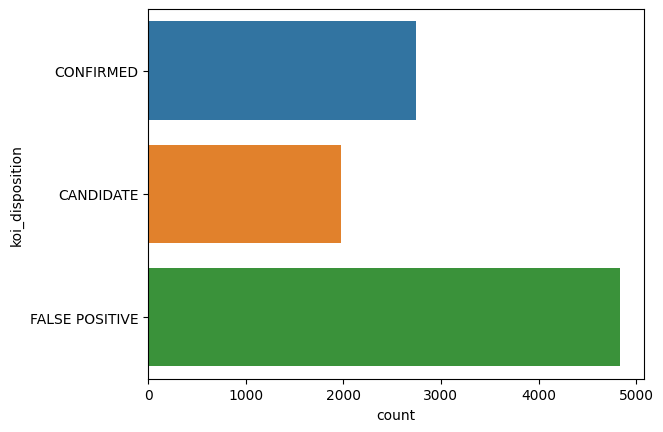

In [ ]:
sns.countplot(data=df, y='koi_disposition', hue='koi_disposition')

In [ ]:
# Downcasting type
num_col, float_col = df.select_dtypes(include=np.int64).columns.to_list(), df.select_dtypes(include=np.float64).columns.to_list()

df[num_col] = df[num_col].apply(pd.to_numeric, downcast="integer")
df[float_col] = df[float_col].apply(pd.to_numeric, downcast="float")

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9564 entries, 0 to 9563
Data columns (total 35 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   koi_disposition   9564 non-null   object 
 1   koi_score         8054 non-null   float32
 2   koi_period        9564 non-null   float64
 3   koi_eccen         9201 non-null   float32
 4   koi_impact        9201 non-null   float32
 5   koi_duration      9564 non-null   float32
 6   koi_depth         9201 non-null   float32
 7   koi_prad          9201 non-null   float64
 8   koi_teq           9201 non-null   float32
 9   koi_max_sngle_ev  8422 non-null   float32
 10  koi_max_mult_ev   8422 non-null   float64
 11  koi_model_snr     9201 non-null   float32
 12  koi_count         9564 non-null   int8   
 13  koi_num_transits  8422 non-null   float32
 14  koi_bin_oedp_sig  8054 non-null   float32
 15  koi_model_chisq   0 non-null      float32
 16  koi_steff         9201 non-null   float32


In [ ]:
string_columns: list[str] = df.select_dtypes(include="object").columns.to_list()
numerical_columns: list[str] = df.select_dtypes(include="number").columns.to_list()

In [ ]:
if 'koi_model_chisq' in numerical_columns:
  numerical_columns.remove('koi_model_chisq')
  df.drop('koi_model_chisq', axis=1, inplace=True)

In [ ]:
#9564
null_percentage: dict[str, str] = {}
null_dict: dict[str, int] = df.isna().sum().to_dict()
for index, value in null_dict.items():
  null_percentage[index] = str(round(abs((1 -((9564-null_dict[index])/9564)) * 100))) + '%'

In [ ]:
null_percentage

{'koi_disposition': '0%',
 'koi_score': '16%',
 'koi_period': '0%',
 'koi_eccen': '4%',
 'koi_impact': '4%',
 'koi_duration': '0%',
 'koi_depth': '4%',
 'koi_prad': '4%',
 'koi_teq': '4%',
 'koi_max_sngle_ev': '12%',
 'koi_max_mult_ev': '12%',
 'koi_model_snr': '4%',
 'koi_count': '0%',
 'koi_num_transits': '12%',
 'koi_bin_oedp_sig': '16%',
 'koi_steff': '4%',
 'koi_slogg': '4%',
 'koi_srad': '4%',
 'koi_smass': '4%',
 'koi_kepmag': '0%',
 'koi_gmag': '0%',
 'koi_rmag': '0%',
 'koi_jmag': '0%',
 'koi_kmag': '0%',
 'koi_fwm_stat_sig': '11%',
 'koi_fwm_prao': '9%',
 'koi_fwm_pdeco': '9%',
 'koi_dicco_mra': '6%',
 'koi_dicco_msky': '6%',
 'koi_dikco_mra': '6%',
 'koi_dikco_msky': '6%',
 'kepid': '0%',
 'kepoi_name': '0%',
 'kepler_name': '71%'}

In [ ]:
  df.columns

Index(['koi_disposition', 'koi_score', 'koi_period', 'koi_eccen', 'koi_impact',
       'koi_duration', 'koi_depth', 'koi_prad', 'koi_teq', 'koi_max_sngle_ev',
       'koi_max_mult_ev', 'koi_model_snr', 'koi_count', 'koi_num_transits',
       'koi_bin_oedp_sig', 'koi_steff', 'koi_slogg', 'koi_srad', 'koi_smass',
       'koi_kepmag', 'koi_gmag', 'koi_rmag', 'koi_jmag', 'koi_kmag',
       'koi_fwm_stat_sig', 'koi_fwm_prao', 'koi_fwm_pdeco', 'koi_dicco_mra',
       'koi_dicco_msky', 'koi_dikco_mra', 'koi_dikco_msky', 'kepid',
       'kepoi_name', 'kepler_name'],
      dtype='object')

# Data splitting

In [ ]:
identification_columns

['kepid', 'kepoi_name', 'kepler_name']

In [ ]:
X = df.drop(identification_columns, axis=1)
X = X.drop('koi_disposition', axis=1)
ids = df[identification_columns]
y = df['koi_disposition']

In [ ]:
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.25,  random_state=42, stratify=y)

In [ ]:
# Has only zeros
# X_train_val.drop('koi_eccen', axis=1, inplace=True)
# X_test.drop('koi_eccen', axis=1, inplace=True)
X.drop('koi_eccen', axis=1, inplace=True)

In [ ]:
split_features: dict[str, dict[str, Any]] = {}

for i in X_train_val.columns.to_list():
  split_features[i] = {
      'mean': X_train_val[i].mean(),
      'std': X_train_val[i].std(),
      'median': X_train_val[i].median(),
      'min': X_train_val[i].min(),
      'max': X_train_val[i].max(),
  }

split_features_df = pd.DataFrame(split_features).T

In [ ]:
split_features_df
joblib.dump(split_features_df, 'SplitTrain.pkl')

['SplitTrain.pkl']

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.15, random_state=42, stratify=y_train_val)

# Data Preprocessing

In [ ]:
le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_val = le.transform(y_val)
y_test = le.transform(y_test)
print(f"Class mapping: {dict(zip(le.classes_, le.transform(le.classes_)))}")
print(f"\nClass distribution:\n{pd.Series(y_train).value_counts().sort_index()}")

joblib.dump(le, 'LabelEncoding.pkl')

Class mapping: {'CANDIDATE': np.int64(0), 'CONFIRMED': np.int64(1), 'FALSE POSITIVE': np.int64(2)}

Class distribution:
0    1261
1    1751
2    3085
Name: count, dtype: int64


['LabelEncoding.pkl']

In [ ]:
preprocessing_pipeline: Pipeline = Pipeline([
    ('imputer', KNNImputer()),
    ('scaler', RobustScaler()),
    ('selector', SelectKBest(score_func=f_classif, k=25)),
])

joblib.dump(preprocessing_pipeline, 'Pipe.pkl')

['Pipe.pkl']

In [ ]:
X_train = preprocessing_pipeline.fit_transform(X_train, y_train)
X_val = preprocessing_pipeline.transform(X_val)
X_test = preprocessing_pipeline.transform(X_test)

/usr/local/lib/python3.12/dist-packages/sklearn/feature_selection/_univariate_selection.py:111: UserWarning: Features [2] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/usr/local/lib/python3.12/dist-packages/sklearn/feature_selection/_univariate_selection.py:112: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


In [ ]:
smote= SMOTE(sampling_strategy='auto', random_state=42, k_neighbors=5)
X_train, y_train = smote.fit_resample(X_train, y_train) #type: ignore

In [ ]:
joblib.dump(X_train, 'train.pkl')

['train.pkl']

In [ ]:
selected_mask = preprocessing_pipeline.named_steps['selector'].get_support()
feature_scores = preprocessing_pipeline.named_steps['selector'].scores_

selected_features = X.columns[selected_mask]

print("Selected feature names:", selected_features.tolist())

Selected feature names: ['koi_score', 'koi_period', 'koi_impact', 'koi_duration', 'koi_depth', 'koi_prad', 'koi_teq', 'koi_max_sngle_ev', 'koi_max_mult_ev', 'koi_model_snr', 'koi_count', 'koi_num_transits', 'koi_bin_oedp_sig', 'koi_steff', 'koi_slogg', 'koi_srad', 'koi_smass', 'koi_kepmag', 'koi_gmag', 'koi_rmag', 'koi_jmag', 'koi_kmag', 'koi_fwm_stat_sig', 'koi_dicco_msky', 'koi_dikco_msky']


In [ ]:
X_train_tem = pd.DataFrame(X_train, columns=selected_features.tolist())

In [ ]:
preprocess_stats: dict[str, dict[str, Any]] = {}
for i in selected_features.tolist():
  preprocess_stats[i] = {
      'mean': X_train_tem[i].mean(),
      'std': X_train_tem[i].std(),
      'median': X_train_tem[i].median(),
      'min': X_train_tem[i].min(),
      'max': X_train_tem[i].max(),
  }

In [ ]:
joblib.dump(pd.DataFrame(preprocess_stats).T, "Final_Stats.pkl")

['Final_Stats.pkl']

In [ ]:
X_train.shape, X.shape

((9255, 25), (9564, 29))

# Hyperparameter training

In [ ]:
# Defining models

In [ ]:
from typing import Any
models: dict[str, Any] = {
    'XGBoost': XGBClassifier(random_state=42, eval_metric='mlogloss'),
    'LightGBM': LGBMClassifier(random_state=42, verbose=-1),
    'CatBoost': CatBoostClassifier(random_state=42, verbose=0)
}

param_grids: dict[str, dict[str, list[int | Any]]] = {
    'XGBoost': {
        'n_estimators': [100, 200, 300],
        'max_depth': [3, 5, 7],
        'learning_rate': [0.01, 0.1, 0.3],
        'subsample': [0.8, 1.0],
        'colsample_bytree': [0.8, 1.0]
    },
    'LightGBM': {
        'n_estimators': [100, 200, 300],
        'max_depth': [3, 5, 7],
        'learning_rate': [0.01, 0.1, 0.3],
        'num_leaves': [31, 50, 70],
        'subsample': [0.8, 1.0]
    },
    'CatBoost': {
        'iterations': [100, 200, 300],
        'depth': [3, 5, 7],
        'learning_rate': [0.01, 0.1, 0.3],
        'l2_leaf_reg': [1, 3, 5]
    }
  }

In [ ]:
results: dict[str, dict[str, Any]] = {}

In [ ]:
for name, definition in models.items():
  print(f"Running {name}")
  grid_search = GridSearchCV(
      estimator=definition,
      param_grid=param_grids[name],
      cv=6,
      scoring='accuracy',
      n_jobs=-1,
      verbose=1
  )
  grid_search.fit(X_train, y_train)
  results[name] = {
    'best_params': grid_search.best_params_,
    'best_cv_score': grid_search.best_score_,
    'best_model': grid_search.best_estimator_
}

Running XGBoost
Fitting 6 folds for each of 108 candidates, totalling 648 fits
Running LightGBM
Fitting 6 folds for each of 162 candidates, totalling 972 fits
Running CatBoost
Fitting 6 folds for each of 81 candidates, totalling 486 fits


In [ ]:
results

{'XGBoost': {'best_params': {'colsample_bytree': 1.0,
   'learning_rate': 0.3,
   'max_depth': 7,
   'n_estimators': 300,
   'subsample': 0.8},
  'best_cv_score': np.float64(0.915299321174606),
  'best_model': XGBClassifier(base_score=None, booster=None, callbacks=None,
                colsample_bylevel=None, colsample_bynode=None,
                colsample_bytree=1.0, device=None, early_stopping_rounds=None,
                enable_categorical=False, eval_metric='mlogloss',
                feature_types=None, feature_weights=None, gamma=None,
                grow_policy=None, importance_type=None,
                interaction_constraints=None, learning_rate=0.3, max_bin=None,
                max_cat_threshold=None, max_cat_to_onehot=None,
                max_delta_step=None, max_depth=7, max_leaves=None,
                min_child_weight=None, missing=nan, monotone_constraints=None,
                multi_strategy=None, n_estimators=300, n_jobs=None,
                num_parallel_tree=None

In [ ]:
joblib.dump(results, 'results_dict.pkl')

['results_dict.pkl']

In [ ]:
results

{'XGBoost': {'best_params': {'colsample_bytree': 1.0,
   'learning_rate': 0.3,
   'max_depth': 7,
   'n_estimators': 300,
   'subsample': 0.8},
  'best_cv_score': np.float64(0.915299321174606),
  'best_model': XGBClassifier(base_score=None, booster=None, callbacks=None,
                colsample_bylevel=None, colsample_bynode=None,
                colsample_bytree=1.0, device=None, early_stopping_rounds=None,
                enable_categorical=False, eval_metric='mlogloss',
                feature_types=None, feature_weights=None, gamma=None,
                grow_policy=None, importance_type=None,
                interaction_constraints=None, learning_rate=0.3, max_bin=None,
                max_cat_threshold=None, max_cat_to_onehot=None,
                max_delta_step=None, max_depth=7, max_leaves=None,
                min_child_weight=None, missing=nan, monotone_constraints=None,
                multi_strategy=None, n_estimators=300, n_jobs=None,
                num_parallel_tree=None

# Model training

In [ ]:
metrics: dict[str, dict[str, Any]] = {}

In [ ]:
X_train_val = np.concatenate([X_train, X_val], axis=0)
y_train_val = np.concatenate([y_train, y_val], axis=0)

lgbm = LGBMClassifier(**results['LightGBM']['best_params'])
lgbm.fit(X_train_val, y_train_val)
y_test_pred = lgbm.predict(X_test)
metrics['LightGBM'] = {
    'accuracy': accuracy_score(y_test, y_test_pred),
    'precision': precision_score(y_test, y_test_pred, average='weighted'),
    'recall': recall_score(y_test, y_test_pred, average='weighted'),
    'f1_score': f1_score(y_test, y_test_pred, average='weighted'),
    'confusion_matrix': confusion_matrix(y_test, y_test_pred),
    'classification_report': classification_report(y_test, y_test_pred)
}

xgbm = XGBClassifier(**results['XGBoost']['best_params'])
xgbm.fit(X_train_val, y_train_val)
y_test_pred = xgbm.predict(X_test)
metrics['XGBoost'] = {
    'accuracy': accuracy_score(y_test, y_test_pred),
    'precision': precision_score(y_test, y_test_pred, average='weighted'),
    'recall': recall_score(y_test, y_test_pred, average='weighted'),
    'f1_score': f1_score(y_test, y_test_pred, average='weighted'),
    'confusion_matrix': confusion_matrix(y_test, y_test_pred),
    'classification_report': classification_report(y_test, y_test_pred)
}

cbm = CatBoostClassifier(**results['CatBoost']['best_params'])
cbm.fit(X_train_val, y_train_val)
y_test_pred = cbm.predict(X_test)
metrics['CatBoost'] = {
    'accuracy': accuracy_score(y_test, y_test_pred),
    'precision': precision_score(y_test, y_test_pred, average='weighted'),
    'recall': recall_score(y_test, y_test_pred, average='weighted'),
    'f1_score': f1_score(y_test, y_test_pred, average='weighted'),
    'confusion_matrix': confusion_matrix(y_test, y_test_pred),
    'classification_report': classification_report(y_test, y_test_pred)
}

vc = VotingClassifier(
    estimators=[
        ('xgb', xgbm),
        ('lgbm', lgbm),
        ('cat', cbm)
    ],
    voting='soft'
)
vc.fit(X_train_val, y_train_val)
y_test_pred = vc.predict(X_test)
metrics['Voting'] = {
    'accuracy': accuracy_score(y_test, y_test_pred),
    'precision': precision_score(y_test, y_test_pred, average='weighted'),
    'recall': recall_score(y_test, y_test_pred, average='weighted'),
    'f1_score': f1_score(y_test, y_test_pred, average='weighted'),
    'confusion_matrix': confusion_matrix(y_test, y_test_pred),
    'classification_report': classification_report(y_test, y_test_pred)
}

In [ ]:
metrics_df: pd.DataFrame = pd.DataFrame(metrics).T

In [ ]:
metrics_df

,accuracy,precision,recall,f1_score,confusion_matrix,classification_report
LightGBM,0.859473,0.857323,0.859473,0.858222,"[[322, 61, 112], [70, 609, 7], [80, 6, 1124]]",precision recall f1-score ...
XGBoost,0.849854,0.849013,0.849854,0.849419,"[[319, 69, 107], [70, 609, 7], [98, 8, 1104]]",precision recall f1-score ...
CatBoost,0.852781,0.852051,0.852781,0.852348,"[[322, 62, 111], [73, 605, 8], [93, 5, 1112]]",precision recall f1-score ...
Voting,0.8578,0.855196,0.8578,0.856301,"[[318, 63, 114], [67, 612, 7], [82, 7, 1121]]",precision recall f1-score ...


# Model persistance and results display

In [ ]:
results['LightGBM']['best_params'], xgbm

({'learning_rate': 0.3,
  'max_depth': 7,
  'n_estimators': 200,
  'num_leaves': 50,
  'subsample': 0.8},
 XGBClassifier(base_score=None, booster=None, callbacks=None,
               colsample_bylevel=None, colsample_bynode=None,
               colsample_bytree=1.0, device=None, early_stopping_rounds=None,
               enable_categorical=False, eval_metric=None, feature_types=None,
               feature_weights=None, gamma=None, grow_policy=None,
               importance_type=None, interaction_constraints=None,
               learning_rate=0.3, max_bin=None, max_cat_threshold=None,
               max_cat_to_onehot=None, max_delta_step=None, max_depth=7,
               max_leaves=None, min_child_weight=None, missing=nan,
               monotone_constraints=None, multi_strategy=None, n_estimators=300,
               n_jobs=None, num_parallel_tree=None, ...))

In [ ]:
X.columns.to_list()

['koi_score',
 'koi_period',
 'koi_impact',
 'koi_duration',
 'koi_depth',
 'koi_prad',
 'koi_teq',
 'koi_max_sngle_ev',
 'koi_max_mult_ev',
 'koi_model_snr',
 'koi_count',
 'koi_num_transits',
 'koi_bin_oedp_sig',
 'koi_steff',
 'koi_slogg',
 'koi_srad',
 'koi_smass',
 'koi_kepmag',
 'koi_gmag',
 'koi_rmag',
 'koi_jmag',
 'koi_kmag',
 'koi_fwm_stat_sig',
 'koi_fwm_prao',
 'koi_fwm_pdeco',
 'koi_dicco_mra',
 'koi_dicco_msky',
 'koi_dikco_mra',
 'koi_dikco_msky']

In [ ]:
# preprocessing_pipeline: Pipeline = Pipeline([
#     ('imputer', KNNImputer()),
#     ('scaler', RobustScaler()),
#     ('selector', SelectKBest(score_func=f_classif, k=25)),
# ])

# nn = NearestNeighbors(n_neighbors=2, algorithm='auto')
# nn.fit(X_train)

xgb_pipe = Pipeline([
    ('preprocessing', preprocessing_pipeline),
    ('model', xgbm)
])

lgbm_pipe = Pipeline([
    ('preprocessing', preprocessing_pipeline),
    ('model', lgbm)
])

cbm_pipe = Pipeline([
    ('preprocessing', preprocessing_pipeline),
    ('model', cbm)
])

vc_pipe = Pipeline([
    ('preprocessing', preprocessing_pipeline),
    ('model', vc)
])

In [ ]:
import joblib

joblib.dump(le, 'LabelEncoding.pkl')
joblib.dump(preprocessing_pipeline, 'PreprocessingPipe.pkl')

joblib.dump(xgb_pipe, 'XGBoostPipe.pkl')
joblib.dump(lgbm_pipe, 'LightGBMPipe.pkl')
joblib.dump(cbm_pipe, 'CatBoostPipe.pkl')
joblib.dump(vc_pipe, 'VotingClassifierPipe.pkl')

joblib.dump(nn, 'NearestNeighbour.pkl')

['NearestNeighbour.pkl']

In [ ]:
results_df.columns

Index(['accuracy', 'precision', 'recall', 'f1_score', 'confusion_matrix',
       'classification_report'],
      dtype='object')

In [ ]:
sns.barplot(data=results_df, x=results_df.index, y='accuracy', hue=results_df.index)
plt.title("Accuracy comparison")
min_acc = min(results_df['accuracy']) - 0.005
max_acc = max(results_df['accuracy']) + 0.005
plt.ylim(min_acc, max_acc)
plt.ylabel('Accuracy')
plt.xlabel('Models')
plt.show()

In [ ]:
sns.barplot(data=results_df, x=results_df.index, y='precision', hue=results_df.index)
plt.title("Precision comparison")
min_acc = min(results_df['precision']) - 0.005
max_acc = max(results_df['precision']) + 0.005
plt.ylim(min_acc, max_acc)
plt.ylabel('Precision')
plt.xlabel('Models')
plt.show()

In [ ]:
sns.barplot(data=results_df, x=results_df.index, y='recall', hue=results_df.index)
plt.title("Recall comparison")
min_acc = min(results_df['recall']) - 0.005
max_acc = max(results_df['recall']) + 0.005
plt.ylim(min_acc, max_acc)
plt.ylabel('Recall')
plt.xlabel('Models')
plt.show()

In [ ]:
sns.barplot(data=results_df, x=results_df.index, y='f1_score', hue=results_df.index)
plt.title("F1 score comparison")
min_acc = min(results_df['f1_score']) - 0.005
max_acc = max(results_df['f1_score']) + 0.005
plt.ylim(min_acc, max_acc)
plt.ylabel('F1 score')
plt.xlabel('Models')
plt.show()

# KNN Neighbours
